# PRSmix Analysis for Predicting SAT Scores in African 

### Project Description
This project evaluates the use of PRSmix (a polygenic risk score integration method using Elastic Net) to predict a continuous trait (SAT scores) in a continental African sample. It compares PRSmix performance to that of individual PRS models from the PGS Catalog.

### Objective
- Evaluate whether integrating multiple PRS scores via PRSmix improves predictive performance in a genetically diverse population.
- Compare performance against single-PRS models.
- Provide insights on trait heritability, ancestry transferability, and modeling robustness.


The dataset is a tab-separated .txt file named satdata.txt, containing:
- **SAT**: the trait to predict (target variable).
- **PGSxxxxxx**: polygenic scores from different models.
- **sex, age**: individual-level covariates.
- **PC1–PC10**: population structure (principal components).


### To-do:
- Descriptive statistics: mean, sd
- Descriptive stats: PGS (mean, sd),  sex (, age)

## 1. Imports & Setup

- We use pandas and numpy for data handling.
- matplotlib and seaborn for visualization.
- ElasticNetCV is used for PRSmix modeling.
- LinearRegression is used to benchmark individual PGS.
- train_test_split splits the data for fair evaluation.

In [11]:
# PRSmix Analysis and Comparison with PGS Scores
# =============================================
# This notebook performs PRSmix (via Elastic Net regression) to combine multiple PGS scores
# and compares its performance to individual PGS Catalog scores on SAT prediction in African samples.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm

## 2. Load and Clean the Data

In [36]:
# Load the dataset (tab-separated)
#drops columns not needed for analysis.
data = pd.read_csv("satdta.txt", sep=" ")

print(data.head())

# Drop non-numeric columns not used for PRS modeling
data = data.drop(columns=['PID', 'IID'])

data.shape

   PID  SAT     PGS000109  PGS000186  PGS001238     PGS001973     PGS002191  \
0  000  215 -8.408570e-06   0.014670  -0.000107 -8.999150e-07 -8.087600e-08   
1  001  314  2.086890e-06   0.015446  -0.000009  5.632750e-07  1.082340e-07   
2  002   89 -3.065150e-07   0.015250   0.000613  5.165300e-07  5.457260e-08   
3  003  192 -1.034610e-05   0.015259  -0.000146 -9.378460e-07 -3.460850e-08   
4  004  163 -4.358090e-06   0.014781  -0.000011 -2.181880e-07 -2.629580e-09   

      PGS002343     PGS002373  PGS002415  ...       PC1       PC2       PC3  \
0 -1.076330e-06  1.651480e-07   0.006500  ... -0.002461 -0.002855  0.001409   
1 -5.009190e-07 -9.653350e-08   0.006566  ... -0.006159 -0.003920  0.001161   
2 -7.276900e-07  9.438660e-08   0.006700  ...  0.004775 -0.000314  0.002286   
3 -9.695920e-07 -1.349160e-07   0.006650  ... -0.006420 -0.003474  0.002224   
4 -7.707490e-07 -2.613450e-07   0.006525  ...  0.052691  0.017146 -0.001825   

        PC4       PC5       PC6       PC7       PC

(1624, 37)

## 3. Define Key Columns

In [33]:
# Identify PGS columns
pgs_cols = [col for col in data.columns if col.startswith("PGS")]


# Covariates and outcome
covariates = ["sex", "age"] + [f"PC{i}" for i in range(1, 11)] #Append 
outcome = "SAT"

In [31]:
#Check the columns
pgs_cols
covariates
#outcome

['sex',
 'age',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10']

## 4. Residualize SAT on Covariates
Removes the effect of age, sex, and population structure using linear regression. We work with residuals as the new target variable, isolating the genetic contribution.

In [12]:
# Residualize SAT score on covariates
X_cov = data[covariates]
y = data[outcome]

# Add intercept
X_cov = sm.add_constant(X_cov)

# Fit linear model
model_cov = sm.OLS(y, X_cov).fit()
residuals = model_cov.resid

In [13]:
residuals

0       -19.303786
1        69.747429
2      -133.928209
3       -49.077077
4         0.127288
           ...    
1619     29.993355
1620     69.778699
1621    -83.939848
1622    -45.528819
1623    -82.671795
Length: 1624, dtype: float64

## Descriptive Statistics

### 1. Univariate

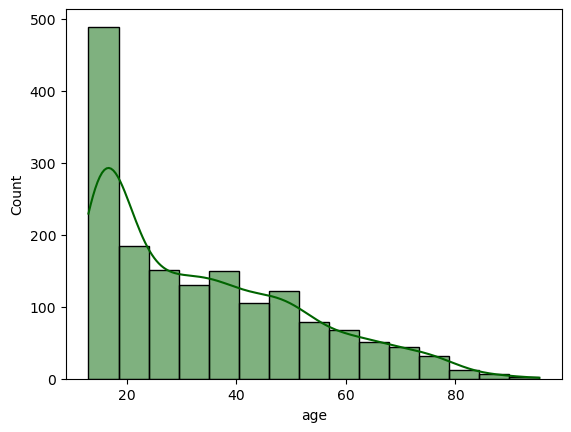

In [97]:
#Age

sns.histplot(data['age'], bins=15, kde=True, color="darkgreen")
plt.show()

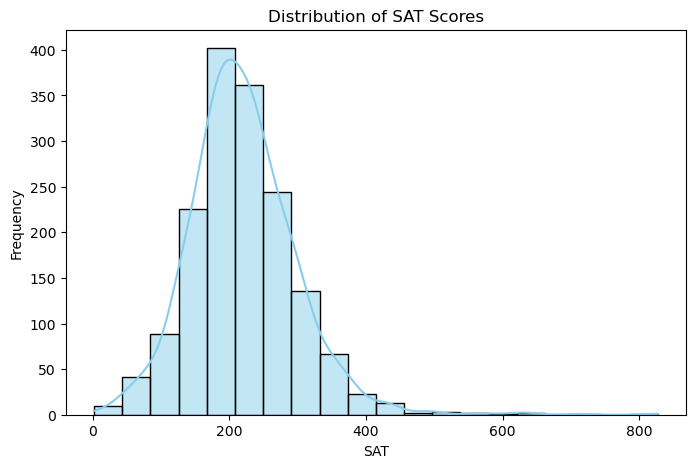

In [98]:
# Distribution of SAT (target trait)
plt.figure(figsize=(8, 5))
sns.histplot(data[outcome], bins=20, kde=True, color='skyblue')
plt.title("Distribution of SAT Scores")
plt.xlabel("SAT")
plt.ylabel("Frequency")
plt.show()

/var/folders/92/w6l9jl312f1c4y3mh783v_r80000gn/T/ipykernel_5171/4059931419.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_counts.index, y=sex_counts.values, palette=["#1f77b4", "#e377c2"])


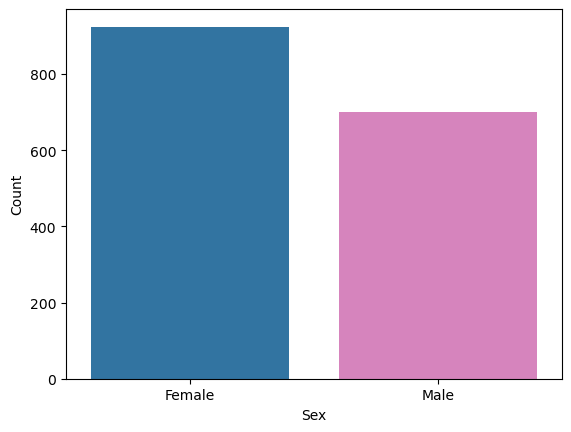

In [104]:

sex_counts = data['Sex_label'].value_counts()
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette=["#1f77b4", "#e377c2"])

plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

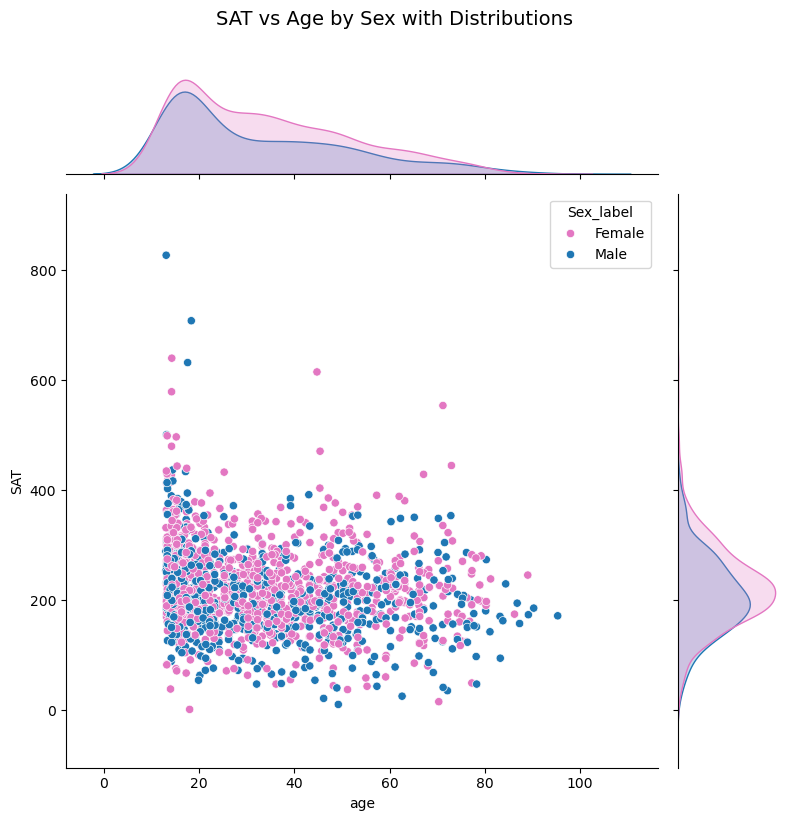

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: map sex to labels
data['Sex_label'] = data['sex'].map({1: 'Male', 2: 'Female'})  # Adjust based on your coding

#sns.reset_defaults()
plt.figure(figsize=(10, 8))
#sns.set(style="whitegrid", font_scale=1.2)

sns.jointplot(
    data=data, x="age", y="SAT", hue="Sex_label",
    kind="scatter", palette={"Male": "#1f77b4", "Female": "#e377c2"},
    height=8, marginal_kws=dict( fill=True),
)
plt.suptitle("SAT vs Age by Sex with Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
#plt.savefig("out.png") 
plt.close()

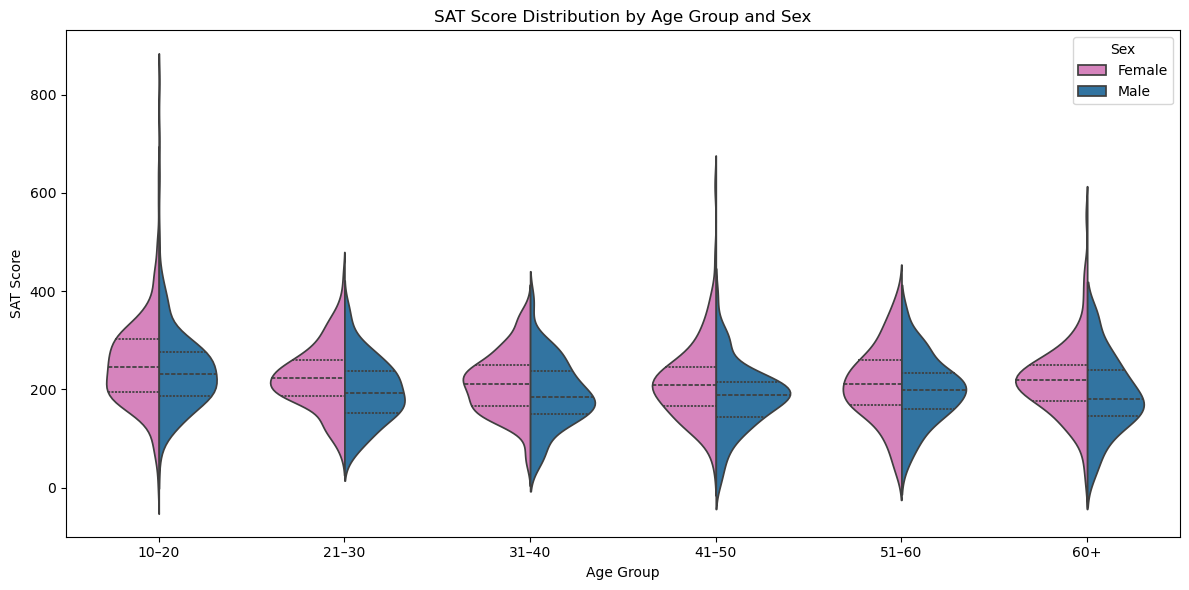

In [92]:
# Bin age into groups
data['age_group'] = pd.cut(data['age'], bins=[10, 20, 30, 40, 50, 60, 100], 
                           labels=["10–20", "21–30", "31–40", "41–50", "51–60", "60+"])

plt.figure(figsize=(12, 6))
sns.violinplot(x="age_group", y="SAT", hue="Sex_label", data=data,
               palette={"Male": "#1f77b4", "Female": "#e377c2"},
               split=True, inner="quartile")
plt.title("SAT Score Distribution by Age Group and Sex")
plt.xlabel("Age Group")
plt.ylabel("SAT Score")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

/var/folders/92/w6l9jl312f1c4y3mh783v_r80000gn/T/ipykernel_5171/2778252066.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pgs_long, x="PGS_ID", y="Score", palette="viridis")


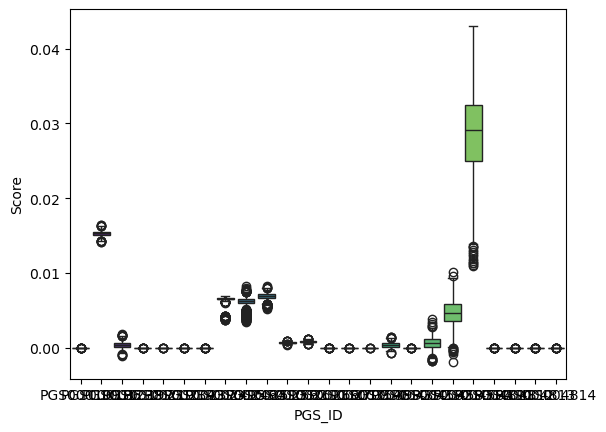

In [105]:
pgs_long = data[pgs_cols].melt(var_name="PGS_ID", value_name="Score")
sns.boxplot(data=pgs_long, x="PGS_ID", y="Score", palette="viridis")
plt.show()

## Prepare Data for Machine Learning

In [14]:
# Prepare PRS data
X_prs = data[pgs_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_prs, residuals, test_size=0.2, random_state=42)

# Fit Elastic Net
enet = ElasticNetCV(cv=5, random_state=42)
enet.fit(X_train, y_train)

# Predict on test set
y_pred = enet.predict(X_test)
prsmix_r2 = r2_score(y_test, y_pred)

In [15]:
y_pred

array([ 3.66722409e+00, -1.62831009e+00,  3.28159346e+00, -4.41516932e+00,
        2.39406997e+00, -1.80938721e+00, -2.22994823e-01, -1.56342612e+00,
        3.71384811e+00,  3.73975684e-01,  6.91218171e-01,  1.34917393e+00,
       -4.83518208e-02, -1.09292811e+00, -3.84653231e+00, -1.93351404e+00,
       -1.48393228e+00,  6.21173447e-01,  6.53023684e-01,  7.00879254e-01,
       -1.73891742e+00,  3.22095999e+00, -1.62083392e+00,  5.50787540e+00,
        1.74972978e+00, -1.23144073e+00, -1.54289118e+00,  2.70543052e-01,
        2.39995401e+00,  1.40978658e+00, -2.05261617e+00,  1.20359470e+00,
       -4.94938807e+00,  1.21776294e+00,  8.92591119e-01, -8.13207877e-01,
        4.55773769e+00,  3.36256582e+00, -1.25023318e+00,  1.39235069e-01,
       -1.64016744e+00, -5.39663745e+00, -1.95608499e+00,  1.57868195e+00,
        8.35626751e-01, -3.86670028e+00,  2.98230189e-01, -2.74841768e+00,
       -1.02958923e-01, -1.55774041e+00,  4.06318146e+00, -4.66618808e-01,
       -1.26828174e+00, -

In [43]:
prsmix_r2**2
np.corrcoef(y_test, y_pred)

(-0.01303054)**2

0.0001697949726916

In [16]:
# Compare with individual PGS R^2
single_r2s = {}
for col in pgs_cols:
    model = LinearRegression()
    model.fit(X_train[[col]], y_train)
    pred = model.predict(X_test[[col]])
    r2 = r2_score(y_test, pred)
    single_r2s[col] = r2

# Visualize R2 scores
sorted_r2s = dict(sorted(single_r2s.items(), key=lambda x: x[1], reverse=True))

In [17]:
sorted_r2s

{'PGS002660': 0.05774617022721973,
 'PGS002709': 0.045664930943274396,
 'PGS002191': 0.03821955168358682,
 'PGS003546': 0.03688209199594128,
 'PGS000186': 0.035557428522486556,
 'PGS000109': 0.02939412522024054,
 'PGS003932': 0.028116477338419488,
 'PGS001238': 0.027969224491741995,
 'PGS001973': 0.02433399076752063,
 'PGS004352': 0.013064846044176792,
 'PGS004813': 0.011731984447007848,
 'PGS004811': 0.011663571763678049,
 'PGS002611': 0.010758437361817585,
 'PGS004812': 0.009791541408642468,
 'PGS004814': 0.009791541408642468,
 'PGS002562': 0.008627144576477952,
 'PGS002343': 0.006697213883553377,
 'PGS002373': 0.0013139157110695354,
 'PGS002415': -0.00020778465732695928,
 'PGS002464': -0.00036090774845032314,
 'PGS002513': -0.0007395497735795953,
 'PGS004583': -0.002176465151797924,
 'PGS004584': -0.009084363223200942,
 'PGS004582': -0.011863496176467647}

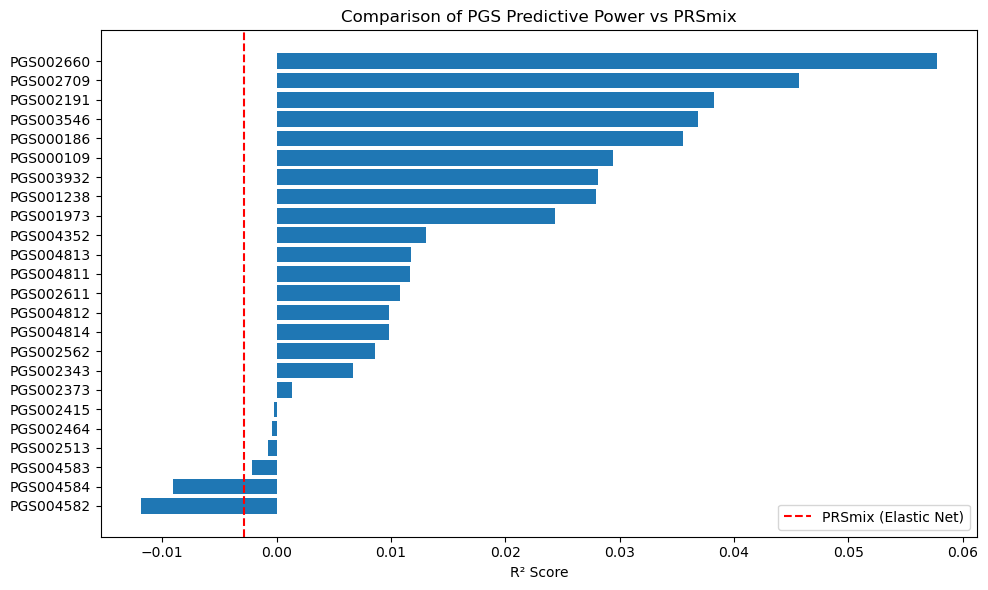

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_r2s.keys())[::-1], list(sorted_r2s.values())[::-1])
plt.axvline(prsmix_r2, color='red', linestyle='--', label='PRSmix (Elastic Net)')
plt.xlabel("R² Score")
plt.title("Comparison of PGS Predictive Power vs PRSmix")
plt.legend()
plt.tight_layout()
plt.show()



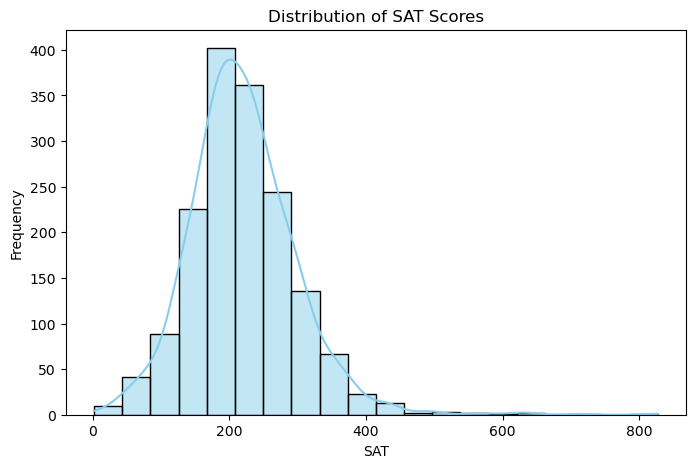

In [19]:
# Distribution of SAT (target trait)
plt.figure(figsize=(8, 5))
sns.histplot(data[outcome], bins=20, kde=True, color='skyblue')
plt.title("Distribution of SAT Scores")
plt.xlabel("SAT")
plt.ylabel("Frequency")
plt.show()

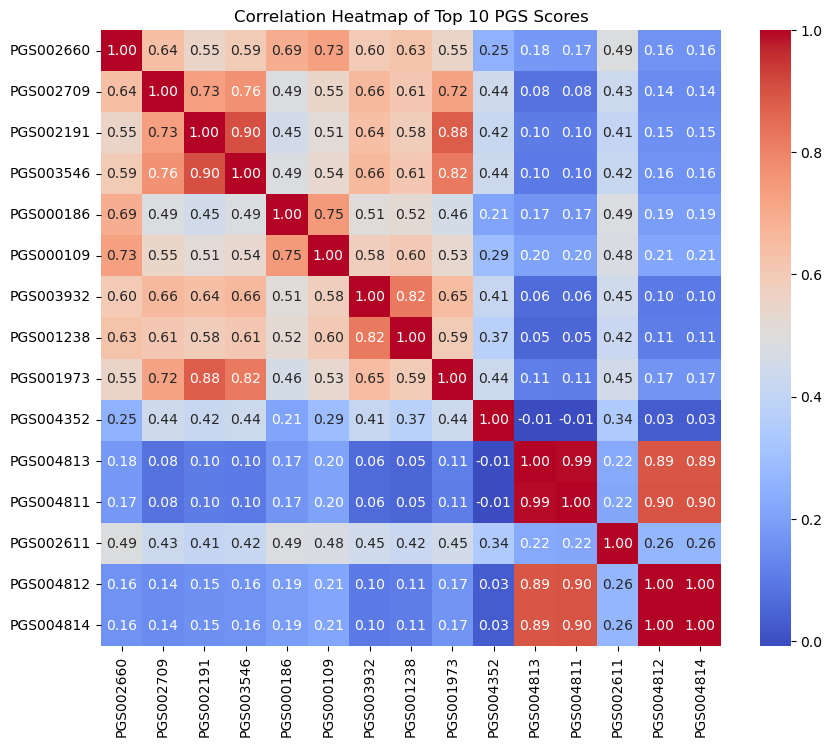

In [29]:
# Correlation heatmap of top PGS predictors
top_pgs = list(sorted_r2s.keys())[:15]
plt.figure(figsize=(10, 8))
sns.heatmap(data[top_pgs].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Top 10 PGS Scores")
plt.show()

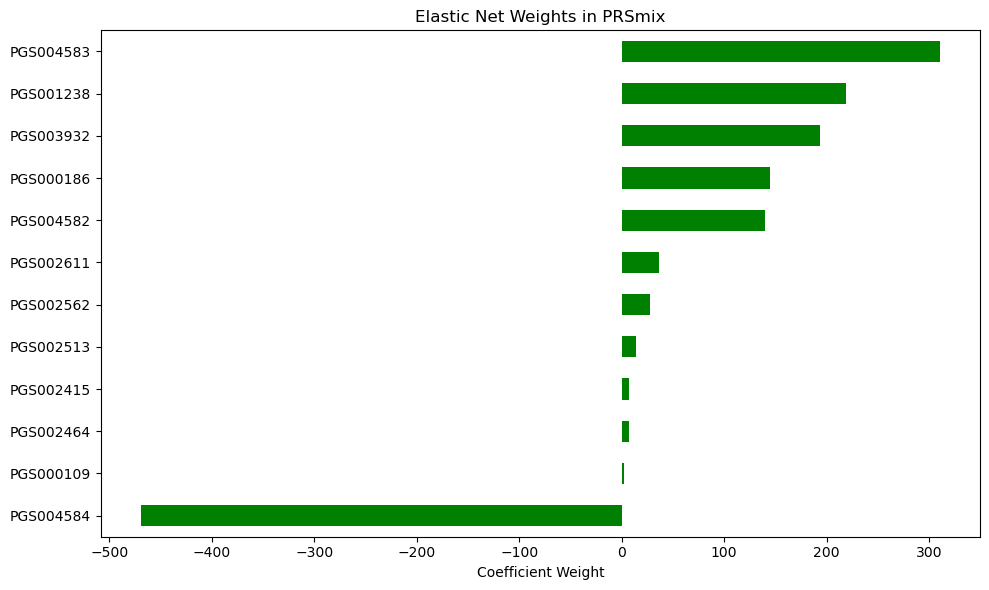

In [37]:
# PRSmix Coefficients
coefs = pd.Series(enet.coef_, index=X_prs.columns)
coefs = coefs[coefs != 0].sort_values()
plt.figure(figsize=(10, 6))
coefs.plot(kind='barh', color='green')
plt.title("Elastic Net Weights in PRSmix")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()

In [25]:
# Final output: Summary Table
summary_df = pd.DataFrame({
    'PGS': list(single_r2s.keys()),
    'R2_score': list(single_r2s.values())
})

summary_df.loc[len(summary_df.index)] = ['PRSmix', prsmix_r2]
summary_df = summary_df.sort_values(by='R2_score', ascending=False).reset_index(drop=True)
summary_df.head(10)

#summary_df

,PGS,R2_score
0,PGS002660,0.057746
1,PGS002709,0.045665
2,PGS002191,0.038220
3,PGS003546,0.036882
4,PGS000186,0.035557
5,PGS000109,0.029394
6,PGS003932,0.028116
7,PGS001238,0.027969
8,PGS001973,0.024334
9,PGS004352,0.013065
